In [1]:
import pandas as pd
import numpy as np

df=pd.read_csv('2019CPS-FSS-household.csv')
df.head(3)


,HRHHID,HRMONTH,HRYEAR4,HURESPLI,HUFINAL,HULANGCODE,HETENURE,HEHOUSUT,HETELHHD,HETELAVL,...,otherRaceInHH,nonCitizenInHH,retiredInHH,disabledInHH,unemployedInHH,universityDegreeInHH,avgAgeHH,avgAgeHHcat,householdSize,householdType
0,581125017600866,12,2019,2,201,0,1,1,1,-1,...,0,0,0,1,0,0,25.250000,2,3,1
1,809001585510960,12,2019,1,201,0,2,1,1,-1,...,0,0,0,0,0,1,18.666667,1,2,1
2,910001990583235,12,2019,1,201,0,2,1,1,-1,...,0,0,0,0,1,0,14.333333,1,2,1


In [2]:
%matplotlib inline

In [3]:
df['foodInsecure'].value_counts(normalize=True)

0    0.929356
1    0.070644
Name: foodInsecure, dtype: float64

<br> As we can see above, the dataset is imbalanced meaning the overall accuracy of the model is 
derived by the majority class

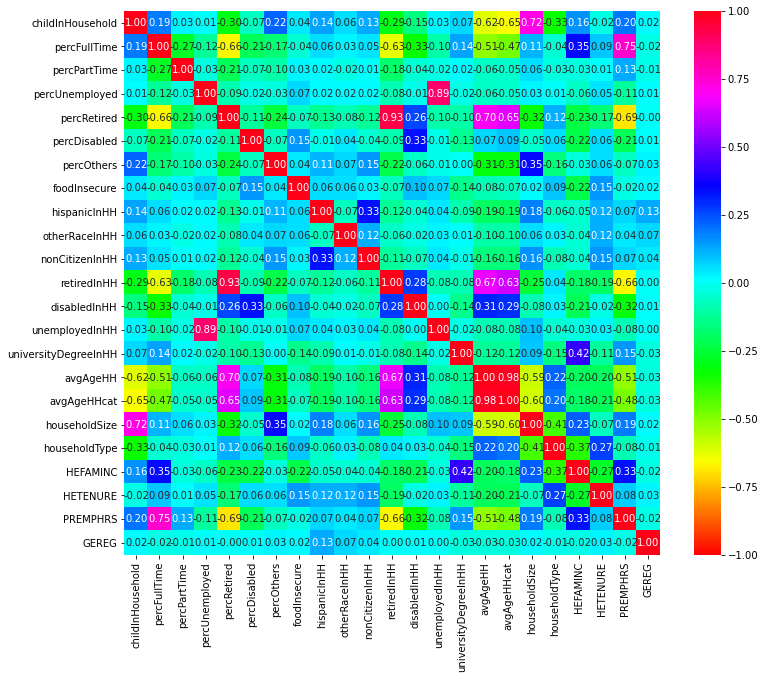

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
z=['householdID',
       'childInHousehold', 'percFullTime', 'percPartTime', 'percUnemployed',
       'percRetired', 'percDisabled', 'percOthers', 'foodInsecure',
       'hispanicInHH', 'otherRaceInHH', 'nonCitizenInHH', 'retiredInHH',
       'disabledInHH', 'unemployedInHH', 'universityDegreeInHH', 'avgAgeHH',
       'avgAgeHHcat', 'householdSize', 'householdType','HEFAMINC','HETENURE','PREMPHRS','GEREG']
filt=z
corr=df[filt].corr().round(2) 
fig, axes=plt.subplots()
fig.set_size_inches(12,10)
sns.heatmap(corr, annot=True,fmt='.2f',vmin=-1,vmax=1, cmap='hsv', center=0,ax=axes)
plt.show()

<br> We removed avgAgeHHcat, percRetired, and percUnemployed because of high correlation with corresponding variables as depicted in the heatmap. In addition we added variables PREMPHRS, and HETENURE because we found the model had a slightly better accuracy with them inlcuded.

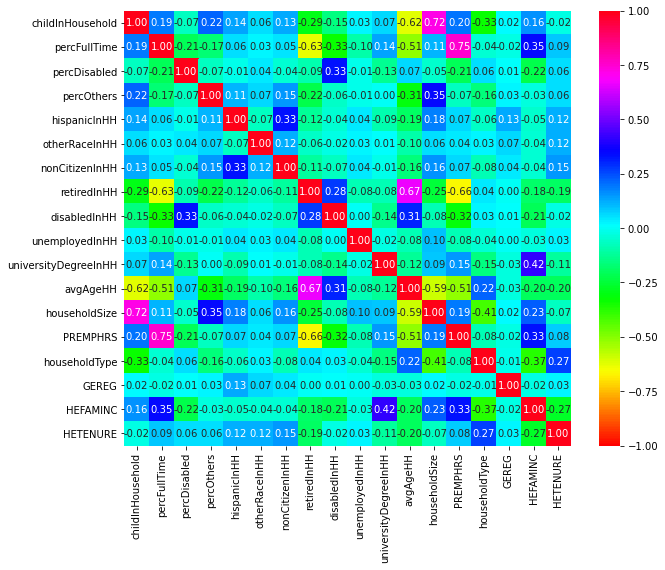

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
z= [
       'childInHousehold', 'percFullTime', 'percDisabled', 'percOthers', 
       'hispanicInHH', 'otherRaceInHH', 'nonCitizenInHH', 'retiredInHH',
       'disabledInHH', 'unemployedInHH', 'universityDegreeInHH', 'avgAgeHH', 'householdSize','PREMPHRS','householdType','GEREG','HEFAMINC','HETENURE',
]
filt=z
corr=df[filt].corr().round(2) 
fig, axes=plt.subplots()
fig.set_size_inches(10,8)
sns.heatmap(corr, annot=True,fmt='.2f',vmin=-1,vmax=1, cmap='hsv', center=0,ax=axes)
plt.show()

<br> We reran the heatmap in order to ensure no further correlation issues that could skew our model results. 
After findings pairs of variables with multicollinearity we would remove one from the predictor variables, using .9 as the threshold to qualify as high multicollinearity

In [6]:
#To check to ensure our data is clean with the additional varaibles we added
df[z].isna().sum(axis=0).sort_values(ascending=False).head()

childInHousehold    0
percFullTime        0
HEFAMINC            0
GEREG               0
householdType       0
dtype: int64

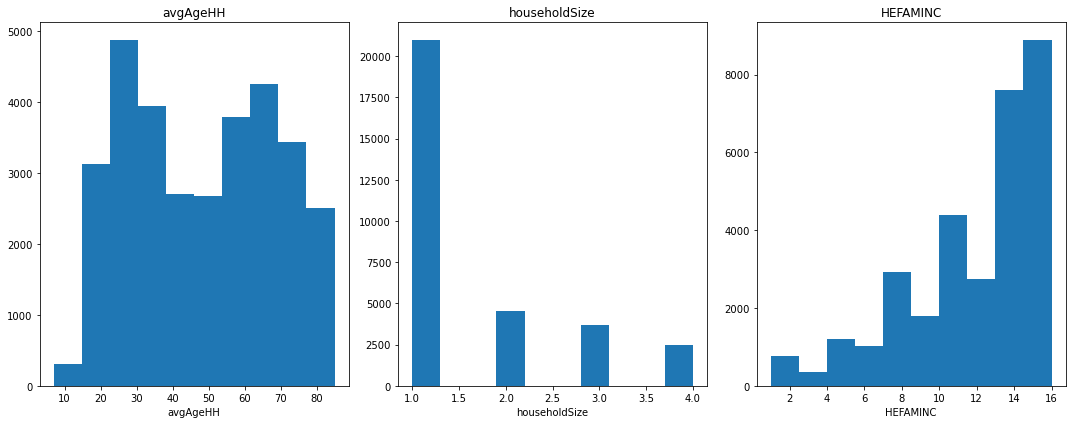

In [7]:
import matplotlib.pylab as plt
continuousVars =  [ 'avgAgeHH', 'householdSize','HEFAMINC']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
for ax, predVars in zip(axes.flatten(), df[continuousVars]):
    ax.hist(df[predVars])
    ax.set_title(predVars)
    ax.set_xlabel(predVars)
plt.tight_layout()
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df[continuousVars]=scaler.fit_transform(df[continuousVars])

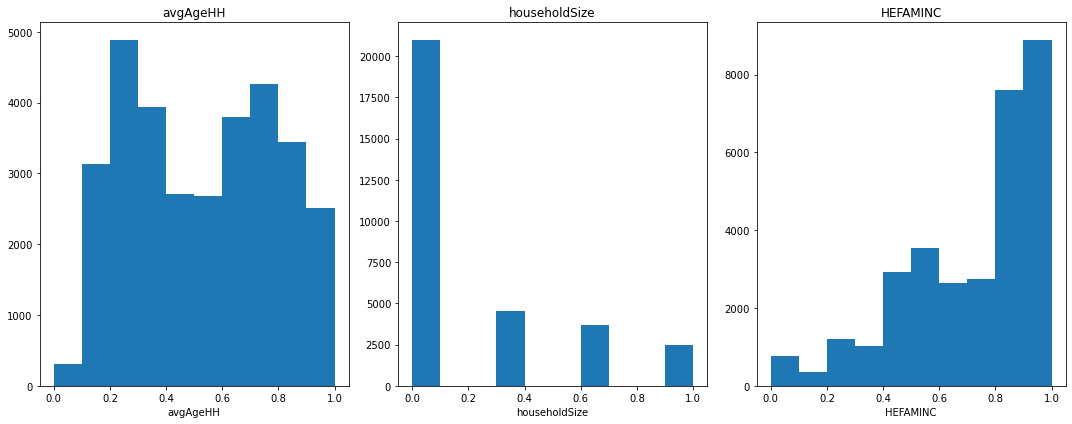

In [9]:
import matplotlib.pylab as plt
continuousVars =  [ 'avgAgeHH', 'householdSize','HEFAMINC']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
for ax, predVars in zip(axes.flatten(), df[continuousVars]):
    ax.hist(df[predVars])
    ax.set_title(predVars)
    ax.set_xlabel(predVars)
plt.tight_layout()
plt.show()

<br> Three continuous variables were looked at to see if scaling changed their heir distribution or not. We ran before and after analysis of the variables and used Min-Max Normalization to standardize them. No difference was found making the variables good to use.

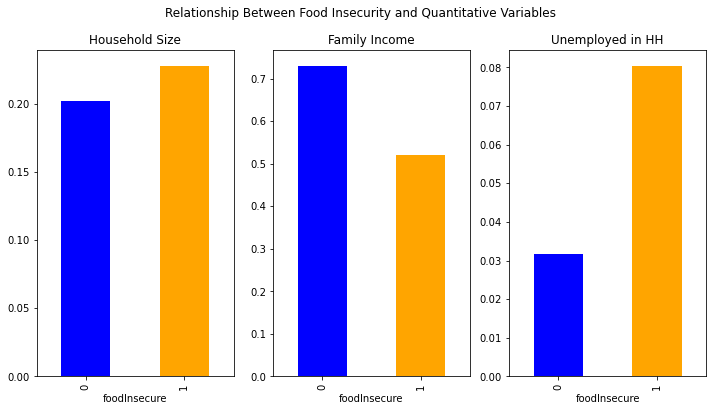

In [10]:
fig,axes =plt.subplots(1,3,figsize=(12,6))
df.groupby("foodInsecure")["householdSize"].mean().plot(kind="bar",color=["blue","orange"],ax=axes[0])
df.groupby("foodInsecure")["HEFAMINC"].mean().plot(kind="bar",color=["blue","orange"],ax=axes[1])
df.groupby("foodInsecure")["unemployedInHH"].mean().plot(kind="bar",color=["blue","orange"],ax=axes[2])
axes[0].set_title('Household Size')
axes[1].set_title('Family Income')
axes[2].set_title('Unemployed in HH')
fig.suptitle('Relationship Between Food Insecurity and Quantitative Variables')
plt.show()

<br> As depicted above, we look at the mean of different variables to see the relationship they have with whether or not the variable will be impactful in determining a households food insecurity. We can anticipate that both family income and whether or not a household has an unemployed member will be significant predictors in the model due to the larger disparities.

In [11]:
z=[
       'childInHousehold', 'percFullTime', 'percDisabled', 'percOthers', 
       'hispanicInHH', 'otherRaceInHH', 'nonCitizenInHH', 'retiredInHH',
       'disabledInHH', 'unemployedInHH', 'universityDegreeInHH', 'avgAgeHH', 'householdSize','PREMPHRS','householdType','GEREG','HEFAMINC','HETENURE']
variableSummary = []
for var in z:
    variableSummary.append({
        'Variable': var,
        'Type': df[var].dtype,
        'Count':df[var].count(),
        'numOfUniqueValues':len(df[var].unique()),
        'unique/count ratio':len(df[var].unique())/df[var].count(),
        'MinValue':df[var].min(),
        'MaxValue':df[var].max()
    })
pd.DataFrame(variableSummary)

,Variable,Type,Count,numOfUniqueValues,unique/count ratio,MinValue,MaxValue
0,childInHousehold,float64,31680,2,0.000063,0.0,1.0
1,percFullTime,float64,31680,23,0.000726,0.0,1.0
2,percDisabled,float64,31680,14,0.000442,0.0,1.0
3,percOthers,float64,31680,22,0.000694,0.0,1.0
4,hispanicInHH,int64,31680,2,0.000063,0.0,1.0
5,otherRaceInHH,int64,31680,2,0.000063,0.0,1.0
6,nonCitizenInHH,int64,31680,2,0.000063,0.0,1.0
7,retiredInHH,int64,31680,2,0.000063,0.0,1.0
8,disabledInHH,int64,31680,2,0.000063,0.0,1.0
9,unemployedInHH,int64,31680,2,0.000063,0.0,1.0


<br> I ran this data preprocessing code to help us decipher which variables are continuous and which are categorical. I had variable definitions provided as well but wanted to ensure the model was accurate so double checked results looking at the number of unqiue values a variable has as well as the unique/count ratio. Using the general rules of thumb lised below:

<br>
1) Variables with type Object (strings) are categorical variables
<br>
2) Numerical variables with unique/count ratio closer to one are likely to be continuous variables
<br>
3) Numerical variables with unique/count ratio closer to zero are likely to be categorical variables
<br>

### Logistic Regression Model

In [12]:
from sklearn.model_selection import train_test_split
outcome='foodInsecure'
predictors= [
       'childInHousehold', 'percFullTime', 'percDisabled', 'percOthers', 
       'hispanicInHH', 'otherRaceInHH', 'nonCitizenInHH', 'retiredInHH',
       'disabledInHH', 'unemployedInHH', 'universityDegreeInHH', 'avgAgeHH', 'householdSize','PREMPHRS','householdType','GEREG','HEFAMINC','HETENURE'
]
X=pd.get_dummies(df[predictors], columns={'GEREG','householdType','HETENURE','PREMPHRS'}, drop_first=True)
y=df[outcome]

from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
X_scaled=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4,random_state=1)

In [13]:
from sklearn.linear_model import LogisticRegression
logit_reg = LogisticRegression(penalty='l1',solver='liblinear',random_state=1,max_iter=10000)
logit_reg.fit(train_X, train_y)


coeff=pd.DataFrame({'Predictor': X.columns, 'coefficient': logit_reg.coef_[0]})
coeff=coeff.append({'Predictor':'intercept', 'coefficient':logit_reg.intercept_[0]}, ignore_index=True)
print(coeff)

y_pred = (logit_reg.predict_proba(train_X)[:,1] >= 0.128).astype(int)
y_pred1 = (logit_reg.predict_proba(valid_X)[:,1] >= 0.128).astype(int)

from dmba import classificationSummary
print('Training set:')
classificationSummary(train_y, y_pred)
print('Test set:')
classificationSummary(valid_y, y_pred1)

               Predictor  coefficient
0       childInHousehold     0.090774
1           percFullTime    -0.113685
2           percDisabled     0.888512
3             percOthers     0.000000
4           hispanicInHH     0.212472
5          otherRaceInHH     0.319670
6         nonCitizenInHH    -0.009602
7            retiredInHH    -0.224562
8           disabledInHH     0.855079
9         unemployedInHH     0.814419
10  universityDegreeInHH    -0.723074
11              avgAgeHH    -1.510782
12         householdSize     0.242956
13              HEFAMINC    -1.939714
14               GEREG_2     0.010360
15               GEREG_3     0.041030
16               GEREG_4     0.071451
17       householdType_2     0.000000
18       householdType_3     0.618081
19       householdType_4     0.245427
20       householdType_5     0.462771
21       householdType_6    -0.047416
22            HETENURE_2     0.450254
23            HETENURE_3     0.000000
24            PREMPHRS_0    -0.252541
25          

In [14]:
from numpy import arange
from sklearn.metrics import f1_score
from numpy import argmax
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(valid_y, to_labels(logit_reg.predict_proba(valid_X)[:,1], t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.128, F-Score=0.31753


<br> Our logistical model had an accuracy of around 85% and was slightly overfitted. We chose liblinear and a l1 penalty as that was the most accurate results when using a penalty. Additionally we manipulated the threshold to .128 in order to increase our true positives while minimizing our false positives. The opitmal threshold was calculated using an f1 score as our predictor, and it turned out to be .128. We did not use class weighted even though the data is imbalanced because it led to too many false positives.
<br>TPR: .502
<br>FPR: .127

### Logistical Lasso Model

In [15]:
from sklearn.linear_model import LogisticRegressionCV


logit_reg_lasso = LogisticRegressionCV(cv=10,penalty='l2',solver='liblinear',n_jobs=-1)#,class_weight='balanced')
logit_reg_lasso.fit(train_X, train_y)

#Printing the fitted parameters:

coeff=pd.DataFrame({'Predictor': X.columns, 'coefficient': logit_reg_lasso.coef_[0]})
coeff=coeff.append({'Predictor':'intercept', 'coefficient':logit_reg_lasso.intercept_[0]}, ignore_index=True)
print(coeff)

y_pred = (logit_reg_lasso.predict_proba(train_X)[:,1] >= 0.28).astype(int)
y_pred1 = (logit_reg_lasso.predict_proba(valid_X)[:,1] >= 0.28).astype(int)

from dmba import classificationSummary
print('Training set:')
classificationSummary(train_y, y_pred)
print('Test set:')
classificationSummary(valid_y, y_pred1)

               Predictor  coefficient
0       childInHousehold    -0.065361
1           percFullTime    -0.175723
2           percDisabled    -0.002164
3             percOthers    -0.027957
4           hispanicInHH    -0.034536
5          otherRaceInHH    -0.048458
6         nonCitizenInHH    -0.019561
7            retiredInHH    -0.119889
8           disabledInHH    -0.048641
9         unemployedInHH    -0.006029
10  universityDegreeInHH    -0.183945
11              avgAgeHH    -0.191399
12         householdSize    -0.063479
13              HEFAMINC    -0.264576
14               GEREG_2    -0.075454
15               GEREG_3    -0.113826
16               GEREG_4    -0.091624
17       householdType_2    -0.013625
18       householdType_3    -0.017078
19       householdType_4    -0.053377
20       householdType_5    -0.060199
21       householdType_6    -0.000299
22            HETENURE_2    -0.061180
23            HETENURE_3    -0.003486
24            PREMPHRS_0    -0.123206
25          

Best Threshold=0.257355, G-Mean=0.649


<ipython-input-16-39008ae1f611>:27: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pyplot.show()


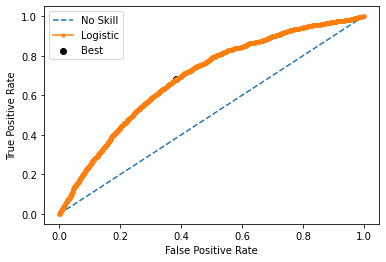

In [16]:
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# predict probabilities
yhat = logit_reg_lasso.predict_proba(train_X)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(train_y, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [17]:
from numpy import arange
from sklearn.metrics import f1_score
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(valid_y, to_labels(logit_reg_lasso.predict_proba(valid_X)[:,1], t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.280, F-Score=0.22260


<br> Next we ran a Lasso model with a penalty of l2 and again using liblinear. Trial and error lead us to this conclusion on which solver and penalty to use after looking at accuracy and type 1 and type 2 errors. It did not remove any variables from the model (coefficient values of 0) leading us to believe all the variables in our model are a factor in determining the classification of a household. Furthermore the optimal threshold changed to .097
<br>TPR: .687
<br>FPR: .239

### Logistical Ridge Model

In [18]:
from sklearn.linear_model import LogisticRegressionCV
logit_reg_ridge = LogisticRegressionCV(cv=10,penalty='l2',solver='newton-cg',n_jobs=-1)#,class_weight='balanced')
logit_reg_ridge.fit(train_X, train_y)

#Printing the fitted parameters:
coeff=pd.DataFrame({'Predictor': X.columns, 'coefficient': logit_reg_ridge.coef_[0]})
coeff=coeff.append({'Predictor':'intercept', 'coefficient':logit_reg_ridge.intercept_[0]}, ignore_index=True)

y_pred = (logit_reg_ridge.predict_proba(train_X)[:,1] >= 0.073).astype(int)
y_pred1 = (logit_reg_ridge.predict_proba(valid_X)[:,1] >= 0.073).astype(int)

from dmba import classificationSummary
print('Training set:')
classificationSummary(train_y, y_pred)
print('Test set:')
classificationSummary(valid_y, y_pred1)

Training set:
Confusion Matrix (Accuracy 0.8530)

       Prediction
Actual     0     1
     0 15623  2048
     1   747   590
Test set:
Confusion Matrix (Accuracy 0.8499)

       Prediction
Actual     0     1
     0 10366  1405
     1   497   404


Best Threshold=0.071491, G-Mean=0.726


<ipython-input-19-08126b7fde09>:26: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pyplot.show()


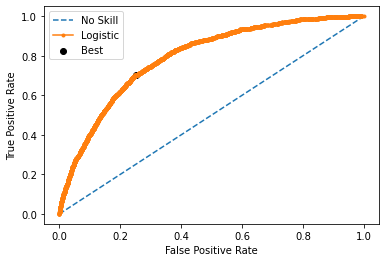

In [19]:
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve

# predict probabilities
yhat = logit_reg_ridge.predict_proba(train_X)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(train_y, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [20]:
from numpy import arange
from sklearn.metrics import f1_score
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(valid_y, to_labels(logit_reg_ridge.predict_proba(valid_X)[:,1], t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.073, F-Score=0.29815


<br> The ridge model was one of our most accurate models with respect to having a low false positive rate, but it was at the cost of having a large portion of false negatives. This was important to us because as much as we want our model to be extremely accurate, we also have to factor in the importance of missing someone who is food insecure that we labeled food secure. Additionally we factored in how our dataset is not consistent with New York State percentage of households that are food insecure menaing we didn't want to allocate our whole budget to this dataset.
<br>TPR: .448
<br>FPR: .119

### Trees Model

In [21]:
outcome='foodInsecure'
predictors= [
       'childInHousehold', 'percFullTime', 'percDisabled', 'percOthers', 
       'hispanicInHH', 'otherRaceInHH', 'nonCitizenInHH', 'retiredInHH',
       'disabledInHH', 'unemployedInHH', 'universityDegreeInHH', 'avgAgeHH', 'householdSize','PREMPHRS','householdType','GEREG','HEFAMINC','HETENURE',
]
X=pd.get_dummies(df[predictors], columns={'GEREG','householdType','HETENURE'}, drop_first=True)
y=df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4,random_state=1)

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': list(range(2, 16)), 
    'min_samples_split': list(range(10, 21)), 
    'min_impurity_decrease': [0.0009, 0.001,.0011], 
}
#pass method through DecisionTreeClassifier(#HERE) to keep a parameter fixed
gridSearch=GridSearchCV(DecisionTreeClassifier(),param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('The best score: ', gridSearch.best_score_)
print('The best parameters: ', gridSearch.best_params_)

#getting the best Tree as a DecisionTreeClassifier object
bestTree = gridSearch.best_estimator_

The best score:  0.9296612051896418
The best parameters:  {'max_depth': 2, 'min_impurity_decrease': 0.0009, 'min_samples_split': 10}


<br> The GridSearchCV is not viable for the scope of this project because although it gives us the model with the best accuracy, because this dataset is imbalanced it will give us a model hevaily carried by True Negatives while failing to account for the importance of true positives. Using this model would defeat the whole purpose of the project in being able to premptively determine food insecure households.

In [23]:
from sklearn.tree import DecisionTreeClassifier
from dmba import plotDecisionTree
smallTree = DecisionTreeClassifier(max_depth=15,min_samples_split=15,min_impurity_decrease=.0009)#,class_weight='balanced')
smallTree.fit(train_X, train_y)
y_pred = (smallTree.predict_proba(train_X)[:,1] >= .08).astype(bool)
y_pred1 = (smallTree.predict_proba(valid_X)[:,1] >= .08).astype(bool)

from dmba import classificationSummary
print('Number of nodes', smallTree.tree_.node_count)
print('Training set:')
classificationSummary(train_y, y_pred, class_names=smallTree.classes_)
print('Test set:')
classificationSummary(valid_y, y_pred1, class_names=smallTree.classes_)

Number of nodes 7
Training set:
Confusion Matrix (Accuracy 0.8157)

       Prediction
Actual     0     1
     0 14807  2864
     1   639   698
Test set:
Confusion Matrix (Accuracy 0.8101)

       Prediction
Actual    0    1
     0 9812 1959
     1  447  454


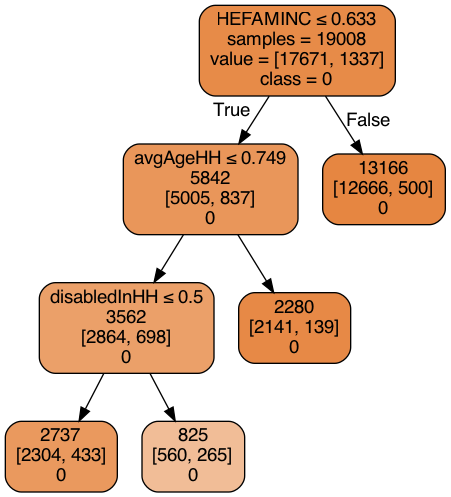

In [24]:
plotDecisionTree(smallTree, feature_names=train_X.columns, class_names=smallTree.classes_)

Best Threshold=0.060965, G-Mean=0.670


<ipython-input-25-8b59d449aeea>:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pyplot.show()


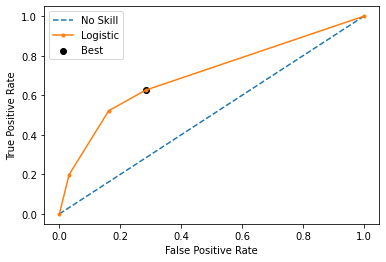

In [25]:
from numpy import sqrt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# predict probabilities
yhat = smallTree.predict_proba(train_X)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(train_y, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

<br> For trees we only convert nomical categorical variables to dummies, which meant only GEREG, householdType, HETENURE had to be converted. Using the min_impurity_decrease of .0009 from the gridSearchCV and understanding the concept that as we reduced 
min_samples_split and max_depth for this dataset our model will get more accurate but not be able to properly predict food security we trial and errored different scenarios as well as thresholds.
<br>TPR: .501
<br>FPR: .166

### Logisitic Model with Threshold Change

In [26]:
outcome='foodInsecure'
predictors= [
       'childInHousehold', 'percFullTime', 'percDisabled', 'percOthers', 
       'hispanicInHH', 'otherRaceInHH', 'nonCitizenInHH', 'retiredInHH',
       'disabledInHH', 'unemployedInHH', 'universityDegreeInHH', 'avgAgeHH', 'householdSize','PREMPHRS','householdType','GEREG','HEFAMINC','HETENURE'
]
X=pd.get_dummies(df[predictors], columns={'GEREG','householdType','HETENURE','PREMPHRS'}, drop_first=True)
y=df[outcome]
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
X_scaled=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4,random_state=4)
logit_reg = LogisticRegression(penalty='none',solver='newton-cg')#,class_weight="balanced")
logit_reg.fit(train_X, train_y)

LogisticRegression(penalty='none', solver='newton-cg')

<br> We decided to make HEFAMINC and householdType into a quantitative variable even though it could be interpreted as a categorical. We did this because family income although asked in a multiple choice questions, there were 16 different potential responses. Additionally householdType was thought of in the same way. We also switched the regression to have no penalty and used a newton-cg solver.

In [27]:
logit_reg = LogisticRegression(penalty='none',solver='newton-cg')#,class_weight="balanced")
logit_reg.fit(train_X, train_y)

print('\n Without Threshold')
print('\n\n Error on the training set:')
classificationSummary(train_y,logit_reg.predict(train_X))

print('\n\n Error on the test set:')
classificationSummary(valid_y,logit_reg.predict(valid_X))


 Without Threshold


 Error on the training set:
Confusion Matrix (Accuracy 0.9266)

       Prediction
Actual     0     1
     0 17570    92
     1  1304    42


 Error on the test set:
Confusion Matrix (Accuracy 0.9285)

       Prediction
Actual     0     1
     0 11739    41
     1   865    27


In [28]:
y_pred = (logit_reg.predict_proba(train_X)[:,1] >= 0.131).astype(int)
y_pred1 = (logit_reg.predict_proba(valid_X)[:,1] >= 0.131).astype(int)

print('Training set:')
classificationSummary(train_y, y_pred)
print('Test set:')
classificationSummary(valid_y, y_pred1)

Training set:
Confusion Matrix (Accuracy 0.8556)

       Prediction
Actual     0     1
     0 15576  2086
     1   658   688
Test set:
Confusion Matrix (Accuracy 0.8531)

       Prediction
Actual     0     1
     0 10392  1388
     1   474   418


[[15576  2086]
 [  658   688]]


<ipython-input-29-c01e47870c8f>:32: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


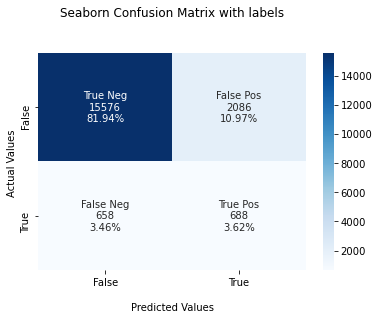

In [29]:
from sklearn.metrics import confusion_matrix
y_pred2=logit_reg.predict(train_X)
#Generate the confusion matrix
cf_matrix = confusion_matrix(train_y, y_pred)

print(cf_matrix)
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()


<ipython-input-30-02d019f27f66>:27: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


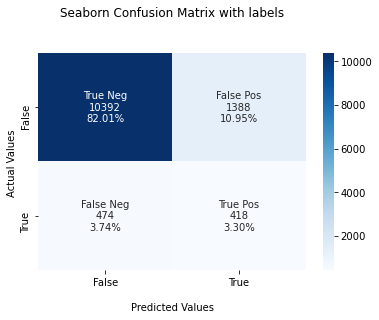

In [30]:
import seaborn as sns
cf_matrix = confusion_matrix(valid_y, y_pred1)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Best Threshold=0.064394, G-Mean=0.745


<ipython-input-31-893027a5afc9>:27: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pyplot.show()


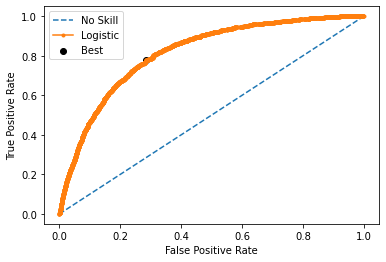

In [31]:
# roc curve for logistic regression model with optimal threshold
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve

# predict probabilities
yhat = logit_reg.predict_proba(train_X)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(train_y, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [32]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(valid_y, to_labels(logit_reg.predict_proba(valid_X)[:,1], t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.131, F-Score=0.30986


<br> Our logistical model with no penalty and a different threshold was our most effective as it was able to determine about 50% of the food insecure households as 1 while maintaining a sufficient accuracy in accordance with other models. For this model we set the threshold to .131 in accordance with the f1 score. We also mapped the differences between the effects of changing the threshold and leaving it at .5 to signify the importance of manipulating it. 


<br>TPR: .468
<br>FPR: .117

# Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
outcome='foodInsecure'
predictors= [
       'childInHousehold', 'percFullTime', 'percDisabled', 'percOthers', 
       'hispanicInHH', 'otherRaceInHH', 'nonCitizenInHH', 'retiredInHH',
       'disabledInHH', 'unemployedInHH', 'universityDegreeInHH', 'avgAgeHH', 'householdSize','PREMPHRS','householdType','GEREG','HEFAMINC','HETENURE',
]
X=pd.get_dummies(df[predictors], columns={'GEREG','householdType','HETENURE'}, drop_first=True)
y=df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4,random_state=1)


param_grid = {
    'max_depth': list(range(10, 15)), 
    'min_samples_split': list(range(15, 20)), 
    'min_impurity_decrease': [0.0009, 0.001, 0.0011], 
}
gridSearch = GridSearchCV(RandomForestClassifier(n_estimators=200,random_state=1, n_jobs=-1, class_weight= 'balanced'), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Best score: ', gridSearch.best_score_)
print('Best parameters: ', gridSearch.best_params_)

bestTree = gridSearch.best_estimator_
print('Training set:')
classificationSummary(train_y, bestTree.predict(train_X), class_names=bestTree.classes_)
print('Test set:')
classificationSummary(valid_y, bestTree.predict(valid_X), class_names=bestTree.classes_)

Best score:  0.7359009734834032
Best parameters:  {'max_depth': 12, 'min_impurity_decrease': 0.0009, 'min_samples_split': 16}
Training set:
Confusion Matrix (Accuracy 0.7327)

       Prediction
Actual     0     1
     0 12877  4794
     1   287  1050
Test set:
Confusion Matrix (Accuracy 0.7196)

       Prediction
Actual    0    1
     0 8444 3327
     1  226  675


Here, we have balanced the class weights for the RandomForestClassifier. The model effectively identifies a high number of the true positive (food insecure households). However, it also predicts many of the negatives as positives which can prove disadvantageous and costly in terms of policy-making. While this model is well in identifying true positives, the low accuracy overall makes the model not optimal.

TPR: .750
FPR: .281

In [34]:
pd.DataFrame({'Predictor': train_X.columns, 'importance': bestTree.feature_importances_}).sort_values(by='importance', ascending=False)

,Predictor,importance
14,HEFAMINC,0.351688
10,universityDegreeInHH,0.136904
23,HETENURE_2,0.124909
11,avgAgeHH,0.107735
8,disabledInHH,0.056159
2,percDisabled,0.053810
7,retiredInHH,0.035173
19,householdType_3,0.027131
1,percFullTime,0.014838
13,PREMPHRS,0.014617


# Boosted Trees

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
boostedTree= GradientBoostingClassifier(n_estimators=1000)
boostedTree.fit(train_X, train_y)
print('Training set:')
classificationSummary(train_y, boostedTree.predict(train_X), class_names=boostedTree.classes_)
print('Test set:')
classificationSummary(valid_y, boostedTree.predict(valid_X), class_names=boostedTree.classes_)

Training set:
Confusion Matrix (Accuracy 0.9454)

       Prediction
Actual     0     1
     0 17627    44
     1   994   343
Test set:
Confusion Matrix (Accuracy 0.9227)

       Prediction
Actual     0     1
     0 11614   157
     1   823    78


Here we have increased the number of boosting stages to perform (n_estimators) within the limitations of both time and computation power required by the higher number of estimators. This increase ensures that the model does not overfit as boosted trees tend to do so. However, as can be seen from the higher accuracy on the training set, the model is still overfitting by 2.27%. Additionally, the model is not accurate in identifying the true positives even with the relative high accuracy.

TPR: .085

FPR: .013

In [36]:
pd.DataFrame({'Predictor': train_X.columns, 'importance': boostedTree.feature_importances_}).sort_values(by='importance', ascending=False)

,Predictor,importance
11,avgAgeHH,0.266509
14,HEFAMINC,0.245036
8,disabledInHH,0.071026
2,percDisabled,0.067921
23,HETENURE_2,0.041108
13,PREMPHRS,0.035827
19,householdType_3,0.034552
10,universityDegreeInHH,0.030103
9,unemployedInHH,0.025124
12,householdSize,0.024097


In [91]:
from numpy import loadtxt
from xgboost import XGBClassifier

# fit model no training data
model = XGBClassifier(max_depths=3, min_child_weight=2, reg_alpha=8, gamma=0, n_estimators=9, subsample=.8, colsample_bytree= .8, n_jobs=-1)
train_X, train_y = sm.fit_resample(train_X, train_y)
model.fit(train_X, train_y)
print('Training set:')
classificationSummary(train_y, model.predict(train_X), class_names=model.classes_)
print('Test set:')
classificationSummary(valid_y, model.predict(valid_X), class_names=model.classes_)

[14:27:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "max_depths" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training set:
Confusion Matrix (Accuracy 0.9059)

       Prediction
Actual     0     1
     0 13554  1813
     1  1078 14289
Test set:
Confusion Matrix (Accuracy 0.7573)

       Prediction
Actual    0    1
     0 9004 2767
     1  308  593


# Neural Network

In [39]:
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier

In [51]:
outcome='foodInsecure'
predictors= [
       'childInHousehold', 'percFullTime', 'percDisabled', 'percOthers', 
       'hispanicInHH', 'otherRaceInHH', 'nonCitizenInHH', 'retiredInHH',
       'disabledInHH', 'unemployedInHH', 'universityDegreeInHH', 'avgAgeHH', 'householdSize','PREMPHRS','householdType','GEREG','HEFAMINC','HETENURE',
]
X=pd.get_dummies(df[predictors], columns={'GEREG','householdType','HETENURE'}, drop_first=True)
y=df[outcome]
sm=SMOTEENN(random_state=101)

In [52]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4,random_state=1)

train_X, train_y = sm.fit_resample(train_X, train_y)

param_grid = {
    'hidden_layer_sizes': [(1),(2),(3),(4),(5),(6),(7),(8),(9),(10)],
}
gridSearch = GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1),
                         param_grid, cv=5, n_jobs=-1, return_train_score=True)
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)


Initial score:  0.8362163056060858
Initial parameters:  {'hidden_layer_sizes': 9}


/Users/abelmaharjan/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Here we have included in the parameter several different hidden layer sizes to try as values for fine tuning. This returns us the best score of ~.8362 as well as the best parameter of 9 hidden layers.

In [53]:
from dmba import regressionSummary
print('Training set:')
classificationSummary(train_y, gridSearch.predict(train_X), class_names=gridSearch.classes_)
print('Test set:')
classificationSummary(valid_y, gridSearch.predict(valid_X), class_names=gridSearch.classes_)

Training set:
Confusion Matrix (Accuracy 0.8369)

       Prediction
Actual     0     1
     0 10912  2859
     1  2073 14391
Test set:
Confusion Matrix (Accuracy 0.7036)

       Prediction
Actual    0    1
     0 8239 3532
     1  224  677


For the Neural Networks, although we have a relatively high accuracy, the model has shortcomings when as it predicts more false positives. For this model, we want to ensure that we include as many poeple as possible who are food insecure while keeping the false positives low. Thus, we have to make the decision of valuing correctly identifying more food insecure families at a loss or less families but also less of a loss.

TPR: .751
FPR: .300